In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Funzione per la discesa del gradiente
- alpha => learning rate
- tolerance => ciò che ci permette di fermarci quando non ci sono più miglioramenti significativi nella funzione di costo
- theta => parametri da apprendere
- x => features
- y => target
- m => numero di esempi

In [31]:
def gradientDescent(alpha, tolerance, theta, x, y, m):
    
    previousCost = 1000000000000000
    while True:
        h = np.dot(x, theta) # ipotesi, ovvero i valori predetti
        #Discesa del gradiente
        theta = theta - ((alpha * (1/m)) * np.dot((h - y).T, x).T)
        j_cost = (np.sum((h - y)**2))/(2*m)
        diff = previousCost - j_cost
        if diff < tolerance:
            break
        else:
            # aggiornamento costo
            previousCost = j_cost

    return theta

Funzione per calcolare le predizioni
- x_test => features del test set
- theta => parametri derivanti dalla fase di training
Esegue una combinazione lineare tra la matrice delle features x_test e il vettore dei pesi theta

In [32]:
def predictions(x_test, theta):
    pred = np.dot(x_test, theta)
    return pred

Funzione per la valutazione
- prediction => predizioni del modello
- target => target del dataset

In [33]:
def modelEvaluation(prediction, target):
    meanTarget = np.mean(target)

    #R2
    sse = np.sum((prediction-target)**2)
    sst = np.sum((target - meanTarget)**2)
    r2 = 1- (sse/sst)

    #Mean absolute error
    mae = np.mean(np.abs(prediction - target))

    #RMSE
    rmse = np.sqrt((np.sum((prediction - target)**2)) / len(prediction))

    return (r2, rmse)

Funzioni di stampa dei risultati

In [34]:
def printLinRegFunction(theta, data):
    print("########## MODELLO ##########")
    print('\nLGND: ' + data.columns.values[len(theta)] + " = Theta * feature")
    print('\n' + data.columns.values[len(theta)] + " = ")
    for i in range(len(theta)):
        print('\t' + str(round(theta[i], 5)) + ' * ' + data.columns.values[i] + ' +')


def printEvaluationResults(r2, rmse):
    print('\n########## RISULTATI VALUTAZIONE ##########')
    print('\nR2 = ' + str(round(r2, 5)))
    print('Root Mean Squared Error = ' + str(round(rmse, 5)))

### Carico il dataset

In [35]:
dataset = pd.read_csv('cars_numeric.csv')

# è meglio mischaire le righe del dataset
dataset = dataset.sample(frac=1).reset_index(drop=True)

# bisogna inserire la colonna di bias
dataset.insert(0, 'bias', np.ones(dataset.shape[0]), True)

### Valutazione tramite split 70/30

In [36]:
training_set = dataset.head(round(len(dataset)*(70/100)))
test_set = dataset.tail(len(dataset) - len(training_set)).reset_index(drop=True)

#fase di fit
alpha = 0.1
tolerance = 0.000001
x = training_set.drop('price', axis = 1).values
y = training_set['price'].values
m = len(training_set)

#inizializzazione dei theta
# genero un array di theta casuali inizializzati in base ai valori massimi e minimi dei dati 
# target (y) e in base al numero di features nella matrice delle features (x)
theta = np.random.uniform(-(np.max(y)), np.max(y), size=x.shape[1])

finalTheta = gradientDescent(alpha=alpha, tolerance=tolerance, theta=theta, x=x, y=y, m=m)


#Valutazione
x_test = test_set.drop('price', axis = 1).values
predizione = predictions(x_test, finalTheta)
y_dataset = test_set['price'].values

r2, rmse = modelEvaluation(prediction=predizione, target=y_dataset)

### Stampe & grafici

In [37]:
print("VALUTAZIONE DEL MODELLO TRAMITE SPLIT 70/30")
printLinRegFunction(theta=finalTheta, data=dataset)
printEvaluationResults(r2=r2, rmse=rmse)

VALUTAZIONE DEL MODELLO TRAMITE SPLIT 70/30
########## MODELLO ##########

LGND: price = Theta * feature

price = 
	13146.29108 * bias +
	-345.00655 * symboling +
	-182.81807 * normalized-losses +
	-1111.53379 * make +
	1992.40873 * fuel-type +
	818.47664 * aspiration +
	-364.18112 * num-of-doors +
	-395.13604 * body-style +
	-1050.18042 * drive-wheels +
	1469.41981 * engine-location +
	141.64599 * wheel-base +
	1403.95807 * length +
	1108.6521 * width +
	374.43067 * height +
	-493.7737 * curb-weight +
	439.49815 * engine-type +
	1389.0468 * num-of-cylinders +
	4149.0855 * engine-size +
	-858.69397 * fuel-system +
	-312.65395 * bore +
	-630.0351 * stroke +
	-1082.98042 * compression-ratio +
	430.14456 * horsepower +
	735.75937 * peak-rpm +
	-1237.83991 * city-mpg +
	1568.75648 * highway-mpg +

########## RISULTATI VALUTAZIONE ##########

R2 = 0.87092
Root Mean Squared Error = 2478.37803


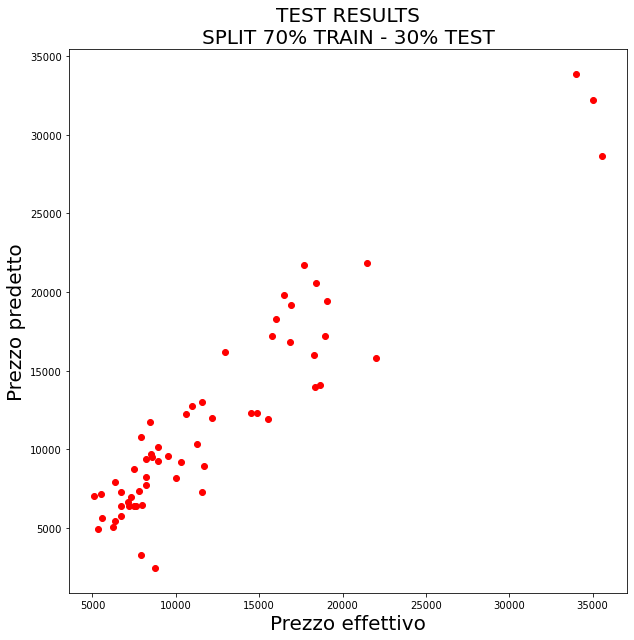

In [38]:
plt.figure(figsize=(10,10))
plt.scatter(x = y_dataset, y = predizione, c='red') 
plt.title("TEST RESULTS\nSPLIT 70% TRAIN - 30% TEST", fontsize=20)
plt.xlabel("Prezzo effettivo", fontsize=20)
plt.ylabel("Prezzo predetto", fontsize=20)
plt.show()

### Cross validazione

Funzione per la cross validazione

In [39]:
def crossValidation(alpha, tolerance, n_folds, dataset):
    foldDimension = dataset.shape[0] // n_folds
    finalTheta = 0
    bestRMSE = 0
    somma_r2 = 0
    somma_rmse = 0

    for i in range(n_folds):
        startFold = i * foldDimension
        endFold = (i+1) * foldDimension

        # per il training set "tolgo" i fold fra startFold e endFold
        # training_set è un nuovo dataframe con le righe indicate dall'intervallo [startFold : endFold] eliminate e con un nuovo indice sequenziale
        training_set = dataset.drop(dataset.index[startFold : endFold]).reset_index(drop = True)
        x_training = training_set.drop('price', axis = 1).values
        y_training = training_set['price'].values

        # uso i fold tolti per il test set
        test_set = dataset[startFold : endFold].reset_index(drop = True)
        x_test = test_set.drop('price', axis = 1).values
        y_test = test_set['price'].values

        m = len(training_set)

        # genero un array di theta casuali inizializzati in base ai valori massimi e minimi dei dati 
        # target (y_training) e in base al numero di features nella matrice delle features (x_training)
        theta = np.random.uniform(-(np.max(y_training)), np.max(y_training), size=x_training.shape[1])
        thetaTrain = gradientDescent(alpha, tolerance, theta, x_training, y_training, m)

        prediction = predictions(x_test=x_test, theta=thetaTrain)

        r2, rmse = modelEvaluation(prediction=prediction, target=y_test)

        if i == 0:
            finalTheta = thetaTrain
            bestRMSE = rmse
        elif rmse < bestRMSE:
            finalTheta = thetaTrain
            bestRMSE = rmse

        somma_r2 = somma_r2 + r2
        somma_rmse = somma_rmse + rmse

    # dividendo le somme per nfolds si ottiene una media delle misure di valutazione su tutti i fold, 
    # rende le stime più rappresentative delle prestazioni del modello sull'intero dataset
    sum_r2_mean = somma_r2/n_folds
    sum_rmse_mean = somma_rmse/n_folds

    return finalTheta, sum_r2_mean, sum_rmse_mean

altra versione della corss validazione (da testare)

In [40]:
def crossValidationV2(alpha, tolerance, n_folds, dataset):
    foldDimension = dataset.shape[0] // n_folds
    finalTheta = None
    bestRMSE = float('inf')
    sum_r2_mean = 0
    sum_rmse_mean = 0

    for i in range(n_folds):
        startFold = i * foldDimension
        endFold = (i + 1) * foldDimension

        training_set = dataset.drop(index=range(startFold, endFold)).reset_index(drop=True)
        x_training = training_set.drop('price', axis=1).values
        y_training = training_set['price'].values

        test_set = dataset.loc[startFold:endFold-1].reset_index(drop=True)
        x_test = test_set.drop('price', axis=1).values
        y_test = test_set['price'].values

        m = len(training_set)
        theta = np.random.uniform(-np.max(y_training), np.max(y_training), size=x_training.shape[1])
        thetaTrain = gradientDescent(alpha, tolerance, theta, x_training, y_training, m)

        prediction = predictions(x_test, thetaTrain)
        r2, rmse = modelEvaluation(prediction, y_test)

        if rmse < bestRMSE:
            bestRMSE = rmse
            finalTheta = thetaTrain

        sum_r2_mean += r2
        sum_rmse_mean += rmse

    avg_r2 = sum_r2_mean / n_folds
    avg_rmse = sum_rmse_mean / n_folds

    return finalTheta, avg_r2, avg_rmse


### Test con cross validazione

Carico il dataset

In [41]:
dataset = pd.read_csv('cars_numeric.csv')

# è meglio mischaire le righe del dataset
dataset = dataset.sample(frac=1).reset_index(drop=True)

# bisogna inserire la colonna di bias
dataset.insert(0, 'bias', np.ones(dataset.shape[0]), True)

In [42]:
print('\n******* TEST CON CROSS-VALIDAZIONE *******')
alpha = 0.01
tolerance = 0.00000001
(finalTheta, r2, rmse) = crossValidation(alpha, tolerance, 10, dataset)

printLinRegFunction(theta=finalTheta, data=dataset)
printEvaluationResults(r2=r2, rmse=rmse)


******* TEST CON CROSS-VALIDAZIONE *******
########## MODELLO ##########

LGND: price = Theta * feature

price = 
	13298.81777 * bias +
	154.43131 * symboling +
	-380.15557 * normalized-losses +
	-843.54969 * make +
	2472.37042 * fuel-type +
	702.82835 * aspiration +
	14.58775 * num-of-doors +
	-362.37214 * body-style +
	-821.51168 * drive-wheels +
	1452.81617 * engine-location +
	116.71354 * wheel-base +
	270.13285 * length +
	912.67238 * width +
	464.50814 * height +
	1700.37947 * curb-weight +
	263.70809 * engine-type +
	1325.8117 * num-of-cylinders +
	3890.26176 * engine-size +
	-892.43527 * fuel-system +
	-291.00226 * bore +
	-532.95798 * stroke +
	-1732.9457 * compression-ratio +
	81.26504 * horsepower +
	905.70914 * peak-rpm +
	-1315.72408 * city-mpg +
	1810.57834 * highway-mpg +

########## RISULTATI VALUTAZIONE ##########

R2 = 0.85818
Root Mean Squared Error = 2811.16006


In [43]:
print('\n******* TEST CON CROSS-VALIDAZIONE V2*******')
alpha = 0.01
tolerance = 0.00000001
(finalTheta, r2, rmse) = crossValidationV2(alpha, tolerance, 10, dataset)

printLinRegFunction(theta=finalTheta, data=dataset)
printEvaluationResults(r2=r2, rmse=rmse)


******* TEST CON CROSS-VALIDAZIONE V2*******
########## MODELLO ##########

LGND: price = Theta * feature

price = 
	13298.81835 * bias +
	154.4362 * symboling +
	-380.1675 * normalized-losses +
	-843.54171 * make +
	2472.71933 * fuel-type +
	702.8015 * aspiration +
	14.5873 * num-of-doors +
	-362.36749 * body-style +
	-821.51951 * drive-wheels +
	1452.81424 * engine-location +
	116.70325 * wheel-base +
	270.1441 * length +
	912.68054 * width +
	464.49736 * height +
	1700.37258 * curb-weight +
	263.70374 * engine-type +
	1325.81521 * num-of-cylinders +
	3890.25175 * engine-size +
	-892.45455 * fuel-system +
	-291.00935 * bore +
	-532.96859 * stroke +
	-1733.26609 * compression-ratio +
	81.28102 * horsepower +
	905.72444 * peak-rpm +
	-1315.69506 * city-mpg +
	1810.57101 * highway-mpg +

########## RISULTATI VALUTAZIONE ##########

R2 = 0.85818
Root Mean Squared Error = 2811.16526
